In [1]:
# !python -m pip install xgboost

In [2]:
# !python -m pip install svgling

In [3]:
# !python -m pip install scikit-multilearn

In [4]:
import requests
import json
from pandas import json_normalize
import ast

import pandas as pd
import numpy as np
import re
import string
import itertools
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, KFold, cross_val_score, cross_validate, StratifiedKFold

from difflib import SequenceMatcher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag, word_tokenize
from wordcloud import WordCloud
import gensim
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import ggplot, aes, geom_line, geom_point, geom_col, geom_bar, geom_density, geom_hline, geom_vline, geom_text, theme, theme_minimal, labs, coord_flip, scale_fill_brewer, scale_color_manual, scale_x_discrete, scale_x_continuous, scale_y_continuous, position_stack, theme_classic, element_blank

In [5]:
nltk.download('maxent_treebank_pos_tagger')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package maxent_treebank_pos_tagger to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package maxent_treebank_pos_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [7]:
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/julianadaikawa/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [8]:
data = pd.read_csv('songs_lyrics_post_preprocessing.csv')
data['lyrics_nlp'] = data.lyrics_nlp.fillna('')

In [9]:
data.groupby('topic')['name'].count().reset_index().sort_values('name',ascending=False)

,topic,name
25,Songs about heartache,769
54,Songs written for a girl,512
40,Songs about sex,489
42,Songs about spirituality or religion,476
3,Songs about an ex-girlfriend or ex-boyfriend,473
0,Songs about a breakup,396
1,Songs about a mother or father,385
19,Songs about drugs,361
52,Songs that are tributes to friends who died,353
15,Songs about death,331


In [10]:
# Label encoding the target to train the models
data['topic_id'] = data['topic'].factorize()[0]
topic_id_df = data[['topic', 'topic_id']].drop_duplicates()

# Dictionaries for future use
topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[['topic_id', 'topic']].values)

In [11]:
# Removing rare words. Word should appear at least at 5 different songs

data_wo_repetition = data.groupby(['name','artist'])['lyrics_nlp'].max().reset_index()
allwords_list = data_wo_repetition['lyrics_nlp'].apply(lambda x: list(set(x.replace(',', ' ').split()))).values
all_words = [item for sublist in allwords_list for item in sublist]
freq_dist = nltk.FreqDist(all_words)
allwords = freq_dist.most_common(len(all_words))
words_over = list(filter(lambda x: x[1]>=5, allwords)) # At least in 5 of songs
rarewords = words_over[-5:]
print('All words: ',len(allwords))
print('Over 5: ', len(words_over))

All words:  15340
Over 5:  6435


In [12]:
# Most frequent words
words_over[:10]

[('go', 7990),
 ('know', 7470),
 ('get', 7465),
 ('like', 6343),
 ('say', 5719),
 ('love', 5501),
 ('see', 5301),
 ('make', 5299),
 ('time', 5264),
 ('come', 5229)]

In [13]:
# Least frequent words
words_over[-10:]

[('deceitful', 5),
 ('auction', 5),
 ('recourse', 5),
 ('burrow', 5),
 ('badness', 5),
 ('militia', 5),
 ('exaggerate', 5),
 ('unsteady', 5),
 ('geneva', 5),
 ('warp', 5)]

In [14]:
# We will separate a random portion of the dataset to test our model later.
train, test = train_test_split(data, test_size=0.1, random_state=42)

In [15]:
# Now let's stack lyrics for each topic
train_grouped = train.groupby('topic')['lyrics_nlp'].apply(list).reset_index(name='lyrics')
train_grouped['lyrics'] = train_grouped['lyrics'].apply(lambda x: ' '.join(x))
train_grouped['bow_lyrics'] = train_grouped['lyrics'].apply(lambda x: nltk.WordPunctTokenizer().tokenize(x))

In [55]:
# Removing rare words
threshold_cut = []
perc_threshold = []
for i in range(2,200,2):
    word_to_remove = list(filter(lambda x: x[1]<i, allwords)) 
    word_to_remove = [w for w,v in word_to_remove]
    words_left = [w for w,v in allwords if w not in word_to_remove]
    perc = (len(allwords)-len(word_to_remove))*100/len(allwords)
    threshold_cut.append(i)
    perc_threshold.append(perc)

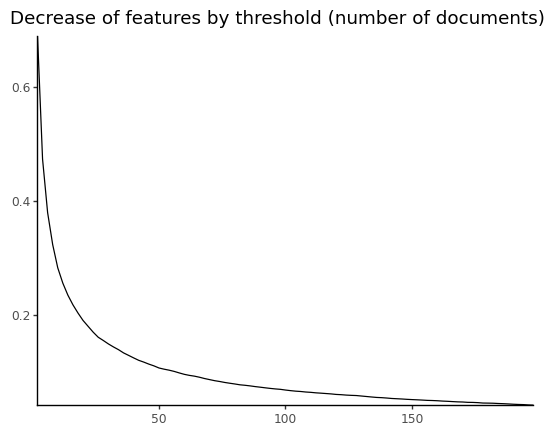

<ggplot: (362145288)>

In [56]:
threshold_words = pd.DataFrame()
threshold_words['threshold_cut'] = threshold_cut
threshold_words['perc_threshold'] = perc_threshold
threshold_words['perc_threshold'] = threshold_words['perc_threshold'].apply(lambda x: x*0.01)

(
    ggplot(threshold_words)
    + aes(x="threshold_cut", y="perc_threshold")  
    + theme_classic()
    + scale_y_continuous(expand=(0, 0, 0, 0))
    + scale_x_continuous(expand=(0, 0, 0, 0))
    + theme(legend_position = (0.5, 0.01),
            legend_title=element_blank())
    + geom_line() 
    # + geom_point(count_topics_remove[count_topics_remove['n'].isin([5,10,15])])
    # + geom_text(count_topics_remove[count_topics_remove['n'].isin([5,10,15])], aes(label='np.round(share,2)'), va="bottom",ha="right", size=9)
    + labs(title='Decrease of features by threshold (number of documents)',x='',y='')
)

In [16]:
# vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
vectorizer = TfidfVectorizer(use_idf=True)
vectors = vectorizer.fit_transform(train.lyrics_nlp.values)
idf = vectorizer.idf_
vectors_test = vectorizer.transform(test.lyrics_nlp.values)
feature_names = vectorizer.get_feature_names_out()
dense = vectors.todense()
denselist = dense.tolist()
X_train = pd.DataFrame(denselist, columns=feature_names)
dense_test = vectors_test.todense()
denselist_test = dense_test.tolist()
X_test = pd.DataFrame(denselist_test, columns=feature_names)
y_train = train.topic_id.values
y_test = test.topic_id.values

# Removing rare words
n_min_docs = 50 
word_to_remove = list(filter(lambda x: x[1]<n_min_docs, allwords)) 
word_to_remove = [w for w,v in word_to_remove]
X_train = X_train[[col for col in X_train.columns if col not in word_to_remove]]
X_test = X_test[[col for col in X_test.columns if col not in word_to_remove]]
print(X_train.shape)

(12569, 1648)


In [17]:
X_train # 1648

,abandon,able,abuse,accept,ache,across,act,actin,action,add,...,yellow,yes,yesterday,yet,yo,york,young,younger,youth,zone
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.034990,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.177075,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12564,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.068245,0.0,0.0,0.0
12565,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
12566,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
12567,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [18]:
# Finding the three most correlated terms with each of the product categories
N = 3
topic_col = []
unigrams_col = []
topic_unigrams_df = pd.DataFrame()
for topic, topic_id in sorted(topic_to_id.items()):
  features_chi2 = chi2(denselist, train.topic_id == topic_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(vectorizer.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  topic_col.append(topic)
  unigrams_col.append(', '.join(unigrams[-N:]))
#   bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("\n==> %s:" %(topic))
#   print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
#   print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))

topic_unigrams_df['topic'] = topic_col
topic_unigrams_df['unigrams'] = unigrams_col
topic_unigrams_df

,topic,unigrams
0,Songs about a breakup,"foo, unfriend, bye"
1,Songs about a mother or father,"father, daddy, mother"
2,Songs about alcohol,"tequila, beer, drink"
3,Songs about an ex-girlfriend or ex-boyfriend,"lo, rekindle, ex"
4,Songs about being away from loved ones,"miss, wanderer, home"
5,Songs about being free,"bondage, freedom, free"
6,Songs about being there for someone,"lade, generator, woohoo"
7,Songs about being young and confused,"sobriety, ripcord, naivety"
8,Songs about change,"evacuation, leathery, change"
9,Songs about cheating,"messin, womanizer, cheat"


In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

seed=42
nb_modeldefault = GaussianNB()
lr_modeldefault = LogisticRegression(random_state=seed, penalty='l2', C=1.0, max_iter=1000) 
rf_modeldefault = RandomForestClassifier(random_state=seed, n_estimators=100, criterion='gini', max_depth=10, min_samples_split=5, min_samples_leaf=5)
xgb_modeldefault = XGBClassifier(random_state=seed, learning_rate=0.1, n_estimators=100, max_depth=10, subsample=0.8, colsample_bytree=0.8)

Naive Bayes

In [59]:
model = nb_modeldefault
scoring = 'f1_macro'
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Macro F1 Train = ", cv_results['train_score'].mean()) 
print("Macro F1 Test = ", cv_results['test_score'].mean()) 

Macro F1 Train =  0.6065324207442299
Macro F1 Test =  0.046319284605556996


Logistic Regression

In [60]:
model = lr_modeldefault
scoring = 'f1_macro'
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Macro F1 Train = ", cv_results['train_score'].mean()) 
print("Macro F1 Test = ", cv_results['test_score'].mean()) 

Macro F1 Train =  0.29509913916849995
Macro F1 Test =  0.12202225118870698


In [21]:
random_grid = [
    {
        'solver': ['saga'],
        'C': np.logspace(-2, 1, 20),
        'penalty': ['l1', 'l2'],
        'max_iter': [1000]
    },
    {
        'solver': ['saga'],
        'C': np.logspace(-2, 1, 20),
        'penalty': ['elasticnet'],
        'max_iter': [1000],
        'l1_ratio': [0.1,0.5,0.8]
    },
    {
        'solver': ['lbfgs'],
        'C': np.logspace(-2, 1, 20),
        'penalty': ['l2'],
        'max_iter': [1000]
    }
    ]
clf = RandomizedSearchCV(LogisticRegression(), random_grid, random_state=seed, n_iter=100, cv=3, verbose=10, return_train_score=True, scoring='f1_macro')
clf.fit(X_train,y_train)
clf.best_params_
clf_final = LogisticRegression(**clf.best_params_).fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV 1/3; 1/100] START C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/3; 1/100] END C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga;, score=(train=0.002, test=0.002) total time=  17.4s
[CV 2/3; 1/100] START C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga
[CV 2/3; 1/100] END C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga;, score=(train=0.002, test=0.002) total time=  13.1s
[CV 3/3; 1/100] START C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga
[CV 3/3; 1/100] END C=0.01438449888287663, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga;, score=(train=0.002, test=0.002) total time=  17.4s
[CV 1/3; 2/100] START C=0.0206913808111479, l1_ratio=0.5, max_iter=1000, penalty=elasticnet, solver=saga
[CV 1/3; 2/100] END C=0.0206913808111479, l

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge


[CV 3/3; 71/100] END C=10.0, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.898, test=0.114) total time=54.2min
[CV 1/3; 72/100] START C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs
[CV 1/3; 72/100] END C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.667, test=0.138) total time=  17.8s
[CV 2/3; 72/100] START C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs
[CV 2/3; 72/100] END C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.663, test=0.140) total time=  23.0s
[CV 3/3; 72/100] START C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs
[CV 3/3; 72/100] END C=4.832930238571752, max_iter=1000, penalty=l2, solver=lbfgs;, score=(train=0.666, test=0.133) total time=  21.8s
[CV 1/3; 73/100] START C=0.029763514416313176, max_iter=1000, penalty=l1, solver=saga
[CV 1/3; 73/100] END C=0.029763514416313176, max_iter=1000, penalty=l1, solver=saga;, score=(train=0.002, test=0.002) total time=  13.4s

TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'solver'

In [22]:
clf_final = LogisticRegression(**clf.best_params_).fit(X_train,y_train)

In [23]:
clf.best_params_

{'solver': 'saga', 'penalty': 'l1', 'max_iter': 1000, 'C': 2.3357214690901213}

In [27]:
coefficients = clf_final.coef_[0]

<Axes: title={'center': 'Feature Importance of the Regression Model'}, ylabel='Feature'>

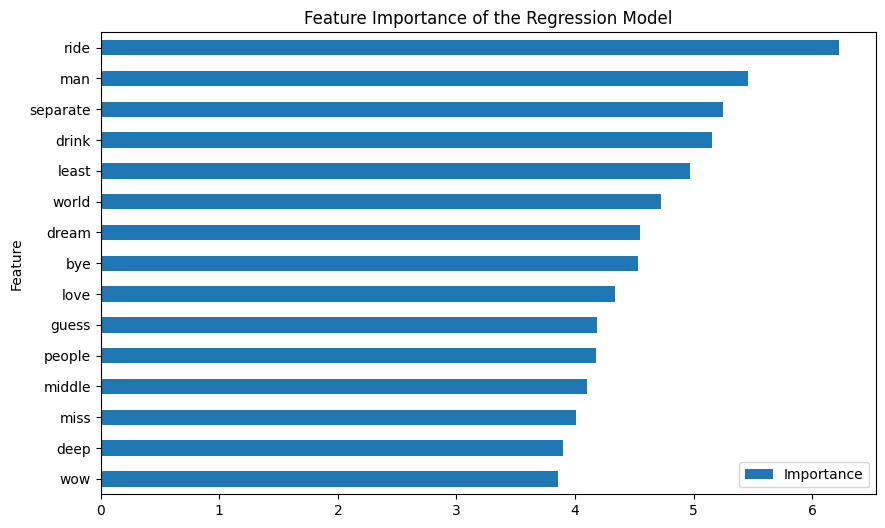

In [42]:
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
feature_importance.head(15).sort_values('Importance', ascending=True).plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), title="Feature Importance of the Regression Model")

In [24]:
pred_train_lr = clf_final.predict(X_train)
pred_test_lr = clf_final.predict(X_test)

In [25]:
classification_report_df_LR = pd.DataFrame(classification_report([id_to_topic[i] for i in y_test], 
                                                              [id_to_topic[i] for i in pred_test_lr], 
                                                              output_dict=True)).transpose()
classification_report_df_LR.sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support
Songs about war,0.393939,0.464286,0.426230,28.000000
Songs about radio stations,1.000000,0.250000,0.400000,4.000000
Songs about people who committed crimes,0.300000,0.333333,0.315789,18.000000
Songs about a mother or father,0.275000,0.366667,0.314286,30.000000
Songs about sex,0.250000,0.386364,0.303571,44.000000
Songs about the environment,0.375000,0.250000,0.300000,12.000000
Songs about loneliness or isolation,0.314286,0.268293,0.289474,41.000000
Songs about computers or technology,0.333333,0.250000,0.285714,12.000000
Songs about being free,0.277778,0.294118,0.285714,17.000000
Songs about traveling,0.333333,0.250000,0.285714,24.000000


In [26]:
classification_report_df_LR_train = pd.DataFrame(classification_report([id_to_topic[i] for i in y_train], 
                                                              [id_to_topic[i] for i in pred_train_lr], 
                                                              output_dict=True)).transpose()
classification_report_df_LR_train.sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support
Songs about war,0.526814,0.625468,0.571918,267.000000
Songs about sex,0.409669,0.723596,0.523152,445.000000
Songs about alcohol,0.504425,0.518182,0.511211,220.000000
Songs about clubbing or a night out,0.470149,0.555066,0.509091,227.000000
Songs about radio stations,0.619048,0.419355,0.500000,31.000000
Songs of or about the Northern Soul movement,1.000000,0.333333,0.500000,3.000000
Songs about music,0.484305,0.507042,0.495413,213.000000
Songs about spirituality or religion,0.394970,0.615207,0.481081,434.000000
Songs about cheating,0.493392,0.457143,0.474576,245.000000
Songs about joy and happiness,0.462766,0.478022,0.470270,182.000000


Random Forest

In [61]:
model = rf_modeldefault
scoring = 'f1_macro'
results = []
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
cv_results = cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring, return_train_score=True)
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Macro F1 Train = ", cv_results['train_score'].mean()) 
print("Macro F1 Test = ", cv_results['test_score'].mean()) 

Macro F1 Train =  0.114313711135448
Macro F1 Test =  0.04615604918986825


In [39]:
random_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10]
    }
clf = RandomizedSearchCV(RandomForestClassifier(), random_grid, random_state=seed, n_iter=100, cv=5, verbose=10, return_train_score=True, scoring='f1_macro')
clf.fit(X_train,y_train)
clf.best_params_
clf_final = RandomForestClassifier(**clf.best_params_).fit(X_train,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5; 1/100] START max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 1/100] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.892, test=0.080) total time=  51.8s
[CV 2/5; 1/100] START max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 1/100] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.891, test=0.087) total time=  51.9s
[CV 3/5; 1/100] START max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 1/100] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.892, test=0.082) total time=  51.1s
[CV 4/5; 1/100] START max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 1/100] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.890, test=0.083) total time=  52.5s
[CV 5/5; 1/100] START max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 1/100] END max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.900, test=0.084) total time=  52.2s
[CV 1/5; 2/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 2/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.117, test=0.036) total time=   5.8s
[CV 2/5; 2/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 2/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.114, test=0.037) total time=   5.6s
[CV 3/5; 2/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 2/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.112, test=0.040) total time=   5.5s
[CV 4/5; 2/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 2/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.113, test=0.032) total time=   5.7s
[CV 5/5; 2/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 2/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.114, test=0.034) total time=   5.7s
[CV 1/5; 3/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 3/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.939, test=0.075) total time=  33.9s
[CV 2/5; 3/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 3/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.935, test=0.083) total time=  34.2s
[CV 3/5; 3/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 3/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.934, test=0.080) total time=  33.8s
[CV 4/5; 3/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 3/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.935, test=0.077) total time=  34.5s
[CV 5/5; 3/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 3/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.941, test=0.085) total time=  34.2s
[CV 1/5; 4/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 4/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.938, test=0.079) total time=  22.7s
[CV 2/5; 4/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 4/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.932, test=0.088) total time=  22.3s
[CV 3/5; 4/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 4/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.934, test=0.091) total time=  22.2s
[CV 4/5; 4/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 4/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.934, test=0.080) total time=  22.3s
[CV 5/5; 4/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 4/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200;, score=(train=0.941, test=0.085) total time=  22.0s
[CV 1/5; 5/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900
[CV 1/5; 5/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900;, score=(train=0.168, test=0.051) total time=  29.0s
[CV 2/5; 5/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900
[CV 2/5; 5/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900;, score=(train=0.170, test=0.055) total time=  28.9s
[CV 3/5; 5/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900
[CV 3/5; 5/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, n_estimators=900;, score=(train=0.171, test=0.055) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 6/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.859, test=0.073) total time=  22.9s
[CV 2/5; 6/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 6/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.852, test=0.085) total time=  23.0s
[CV 3/5; 6/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 6/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.861, test=0.075) total time=  23.0s
[CV 4/5; 6/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 6/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.853, test=0.079) total time=  23.5s
[CV 5/5; 6/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 6/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.861, test=0.082) total time=  23.1s
[CV 1/5; 7/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 1/5; 7/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.070, test=0.032) total time=   3.7s
[CV 2/5; 7/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 2/5; 7/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.069, test=0.041) total time=   3.7s
[CV 3/5; 7/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 3/5; 7/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.070, test=0.035) total time=   3.7s

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 8/100] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.466, test=0.066) total time=  58.9s
[CV 2/5; 8/100] START max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 8/100] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.492, test=0.072) total time=  58.2s
[CV 3/5; 8/100] START max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 8/100] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.478, test=0.069) total time=  54.7s
[CV 4/5; 8/100] START max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 8/100] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.489, test=0.063) total time=  55.1s
[CV 5/5; 8/100] START max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 8/100] END max_depth=60, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.473, test=0.073) total time=  55.4s
[CV 1/5; 9/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 9/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=(train=0.891, test=0.080) total time=  51.5s
[CV 2/5; 9/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 9/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=(train=0.888, test=0.089) total time=  51.4s
[CV 3/5; 9/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 9/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=(train=0.887, test=0.079) total time=  51.0s
[CV 4/5; 9/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 9/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=(train=0.886, test=0.084) total time=  59.1s
[CV 5/5; 9/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 9/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=600;, score=(train=0.890, test=0.082) total time=  54.5s
[CV 1/5; 10/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 10/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.927, test=0.078) total time= 1.6min
[CV 2/5; 10/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 10/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.928, test=0.094) total time= 1.7min
[CV 3/5; 10/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 10/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.935, test=0.088) total time= 1.6min
[CV 4/5; 10/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 10/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.916, test=0.081) total time= 1.5min
[CV 5/5; 10/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 10/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.927, test=0.092) total time= 1.4min
[CV 1/5; 11/100] START max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 1/5; 11/100] END max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.467, test=0.063) total time=  10.9s
[CV 2/5; 11/100] START max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 2/5; 11/100] END max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.486, test=0.071) total time=  10.7s
[CV 3/5; 11/100] START max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200
[CV 3/5; 11/100] END max_depth=60, max_features=sqrt, min_samples_leaf=10, min_samples_split=2, n_estimators=200;, score=(train=0.478, test=0.066) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 12/100] END max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.526, test=0.061) total time=  27.5s
[CV 2/5; 12/100] START max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 12/100] END max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.537, test=0.073) total time=  27.9s
[CV 3/5; 12/100] START max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 12/100] END max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.511, test=0.068) total time=  27.6s
[CV 4/5; 12/100] START max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 12/100] END max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.532, test=0.064) total time=  31.5s
[CV 5/5; 12/100] START max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 12/100] END max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=500;, score=(train=0.527, test=0.069) total time=  30.2s
[CV 1/5; 13/100] START max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600
[CV 1/5; 13/100] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=(train=0.861, test=0.074) total time=  46.6s
[CV 2/5; 13/100] START max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600
[CV 2/5; 13/100] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=(train=0.863, test=0.086) total time=  45.6s
[CV 3/5; 13/100] START max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600
[CV 3/5; 13/100] END max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=600;, score=(train=0.863, test=0.074) total time=  46

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 15/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=(train=0.862, test=0.080) total time=  39.7s
[CV 2/5; 15/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 15/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=(train=0.859, test=0.085) total time=  39.2s
[CV 3/5; 15/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 15/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=(train=0.864, test=0.073) total time=  37.8s
[CV 4/5; 15/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 15/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=(train=0.859, test=0.081) total time=  45.0s
[CV 5/5; 15/100] START max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 15/100] END max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=500;, score=(train=0.863, test=0.080) total time=  43.9s
[CV 1/5; 16/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 16/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.944, test=0.086) total time= 1.1min
[CV 2/5; 16/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 16/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.942, test=0.095) total time= 1.1min
[CV 3/5; 16/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 16/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.942, test=0.094) total time=  59.5s
[CV 4/5; 16/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 16/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.943, test=0.086) total time=  59.6s
[CV 5/5; 16/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 16/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.943, test=0.092) total time= 1.0min
[CV 1/5; 17/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 1/5; 17/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.894, test=0.079) total time=  53.1s
[CV 2/5; 17/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 2/5; 17/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.892, test=0.088) total time=  51.6s
[CV 3/5; 17/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600
[CV 3/5; 17/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=(train=0.893, test=0.080) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 19/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.869, test=0.067) total time=  50.7s
[CV 2/5; 19/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 19/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.872, test=0.071) total time=  56.7s
[CV 3/5; 19/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 19/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.874, test=0.068) total time= 1.2min
[CV 4/5; 19/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 19/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.857, test=0.073) total time=  51.9s
[CV 5/5; 19/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 19/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.860, test=0.071) total time=  41.6s
[CV 1/5; 20/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 20/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.945, test=0.080) total time=  23.1s
[CV 2/5; 20/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 20/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.942, test=0.089) total time=  25.8s
[CV 3/5; 20/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 20/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.943, test=0.088) total time=  31.5s
[CV 4/5; 20/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 20/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.938, test=0.082) total time=  25.6s
[CV 5/5; 20/100] START max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 20/100] END max_depth=70, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=200;, score=(train=0.939, test=0.084) total time=  24.9s
[CV 1/5; 21/100] START max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 21/100] END max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=(train=0.433, test=0.063) total time=  44.1s
[CV 2/5; 21/100] START max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 21/100] END max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=(train=0.448, test=0.070) total time=  36.7s
[CV 3/5; 21/100] START max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 21/100] END max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=(train=0.441, test=0.065) total time=  48.6s
[CV 4/5; 21/100] START max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 21/100] END max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=(train=0.441, test=0.060) total time=  40.1s
[CV 5/5; 21/100] START max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 21/100] END max_depth=50, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=700;, score=(train=0.440, test=0.068) total time=  36.4s
[CV 1/5; 22/100] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 1/5; 22/100] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.367, test=0.054) total time=   4.1s
[CV 2/5; 22/100] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 2/5; 22/100] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.374, test=0.060) total time=   3.9s
[CV 3/5; 22/100] START max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100
[CV 3/5; 22/100] END max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100;, score=(train=0.380, test=0.056) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 23/100] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=(train=0.934, test=0.079) total time=  43.3s
[CV 2/5; 23/100] START max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 23/100] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=(train=0.935, test=0.090) total time=  50.7s
[CV 3/5; 23/100] START max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 23/100] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=(train=0.942, test=0.087) total time=  53.3s
[CV 4/5; 23/100] START max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 23/100] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=(train=0.936, test=0.084) total time=  42.9s
[CV 5/5; 23/100] START max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 23/100] END max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=400;, score=(train=0.937, test=0.085) total time=  50.2s
[CV 1/5; 24/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 1/5; 24/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.942, test=0.090) total time=  12.5s
[CV 2/5; 24/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 2/5; 24/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.941, test=0.095) total time=  12.3s
[CV 3/5; 24/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100
[CV 3/5; 24/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100;, score=(train=0.942, test=0.096) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 25/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.872, test=0.078) total time=   8.6s
[CV 2/5; 25/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 25/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.872, test=0.085) total time=   8.5s
[CV 3/5; 25/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 25/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.872, test=0.078) total time=   8.7s
[CV 4/5; 25/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 25/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.882, test=0.073) total time=   8.6s
[CV 5/5; 25/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 25/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.874, test=0.090) total time=   9.2s
[CV 1/5; 26/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 26/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=(train=0.942, test=0.084) total time= 2.4min
[CV 2/5; 26/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 26/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=(train=0.942, test=0.093) total time= 2.0min
[CV 3/5; 26/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 26/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=(train=0.941, test=0.097) total time= 2.0min
[CV 4/5; 26/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 26/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=(train=0.941, test=0.088) total time= 2.0min
[CV 5/5; 26/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 26/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000;, score=(train=0.942, test=0.098) total time= 2.0min
[CV 1/5; 27/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 1/5; 27/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.167, test=0.056) total time=  19.3s
[CV 2/5; 27/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 2/5; 27/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.174, test=0.057) total time=  16.5s
[CV 3/5; 27/100] START max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 3/5; 27/100] END max_depth=20, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.170, test=0.054) total ti

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 28/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700;, score=(train=0.889, test=0.077) total time= 1.1min
[CV 2/5; 28/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 28/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700;, score=(train=0.887, test=0.085) total time= 1.2min
[CV 3/5; 28/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 28/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700;, score=(train=0.887, test=0.075) total time= 1.2min
[CV 4/5; 28/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 28/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700;, score=(train=0.883, test=0.082) total time= 1.1min
[CV 5/5; 28/100] START max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 28/100] END max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=700;, score=(train=0.888, test=0.084) total time= 1.0min
[CV 1/5; 29/100] START max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 29/100] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300;, score=(train=0.266, test=0.058) total time=  13.5s
[CV 2/5; 29/100] START max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 29/100] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300;, score=(train=0.273, test=0.069) total time=  13.2s
[CV 3/5; 29/100] START max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 29/100] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300;, score=(train=0.281, test=0.066) total time=  14.1s
[CV 4/5; 29/100] START max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 29/100] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300;, score=(train=0.270, test=0.065) total time=  13.9s
[CV 5/5; 29/100] START max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 29/100] END max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300;, score=(train=0.256, test=0.059) total time=  13.4s
[CV 1/5; 30/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 1/5; 30/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.889, test=0.079) total time=   8.8s
[CV 2/5; 30/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 2/5; 30/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.877, test=0.088) total time=   8.9s
[CV 3/5; 30/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100
[CV 3/5; 30/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=100;, score=(train=0.885, test=0.081) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 32/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.947, test=0.083) total time= 1.9min
[CV 2/5; 32/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 32/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.945, test=0.090) total time= 1.9min
[CV 3/5; 32/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 32/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.945, test=0.097) total time= 1.9min
[CV 4/5; 32/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 32/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.946, test=0.083) total time= 1.9min
[CV 5/5; 32/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 32/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.946, test=0.090) total time= 1.9min
[CV 1/5; 33/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600
[CV 1/5; 33/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=(train=0.918, test=0.079) total time=  56.2s
[CV 2/5; 33/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600
[CV 2/5; 33/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=(train=0.919, test=0.089) total time=  56.9s
[CV 3/5; 33/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600
[CV 3/5; 33/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600;, score=(train=0.922, test=0.083) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 34/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=(train=0.519, test=0.063) total time=  58.0s
[CV 2/5; 34/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 34/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=(train=0.535, test=0.067) total time= 1.1min
[CV 3/5; 34/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 34/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=(train=0.516, test=0.069) total time= 1.1min
[CV 4/5; 34/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 34/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=(train=0.534, test=0.064) total time= 1.0min
[CV 5/5; 34/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 34/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=1000;, score=(train=0.527, test=0.071) total time= 1.1min
[CV 1/5; 35/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 35/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.948, test=0.090) total time=  39.3s
[CV 2/5; 35/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 35/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.945, test=0.097) total time=  38.5s
[CV 3/5; 35/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 35/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.946, test=0.087) total time=  38.3s
[CV 4/5; 35/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 35/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.946, test=0.087) total time=  40.5s
[CV 5/5; 35/100] START max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 35/100] END max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.946, test=0.090) total time=  39.4s
[CV 1/5; 36/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 36/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700;, score=(train=0.106, test=0.034) total time=  13.5s
[CV 2/5; 36/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 36/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700;, score=(train=0.099, test=0.034) total time=  14.0s
[CV 3/5; 36/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 36/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700;, score=(train=0.104, test=0.038) total time=  15.5s
[CV 4/5; 36/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 36/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700;, score=(train=0.103, test=0.035) total time=  14.7s
[CV 5/5; 36/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 36/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=700;, score=(train=0.101, test=0.030) total time=  16.2s
[CV 1/5; 37/100] START max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 37/100] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=(train=0.939, test=0.089) total time= 1.2min
[CV 2/5; 37/100] START max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 37/100] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=(train=0.941, test=0.096) total time= 1.3min
[CV 3/5; 37/100] START max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 37/100] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=(train=0.941, test=0.089) total time= 1.3min
[CV 4/5; 37/100] START max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 37/100] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=(train=0.935, test=0.089) total time= 1.2min
[CV 5/5; 37/100] START max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 37/100] END max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=600;, score=(train=0.938, test=0.089) total time= 1.2min
[CV 1/5; 38/100] START max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 1/5; 38/100] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=0.911, test=0.072) total time=  34.9s
[CV 2/5; 38/100] START max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 2/5; 38/100] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=0.912, test=0.089) total time=  39.5s
[CV 3/5; 38/100] START max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400
[CV 3/5; 38/100] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=400;, score=(train=0.912, test=0.074) total time=  35.3

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 40/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.518, test=0.064) total time=  35.4s
[CV 2/5; 40/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 40/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.537, test=0.071) total time=  34.7s
[CV 3/5; 40/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 40/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.518, test=0.066) total time=  34.7s
[CV 4/5; 40/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 40/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.538, test=0.065) total time=  35.5s
[CV 5/5; 40/100] START max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 40/100] END max_depth=90, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=600;, score=(train=0.536, test=0.070) total time=  35.4s
[CV 1/5; 41/100] START max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600
[CV 1/5; 41/100] END max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.947, test=0.080) total time= 1.7min
[CV 2/5; 41/100] START max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600
[CV 2/5; 41/100] END max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.945, test=0.090) total time= 1.7min
[CV 3/5; 41/100] START max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600
[CV 3/5; 41/100] END max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600;, score=(train=0.946, test=0.091) total time= 1.6m

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 42/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.822, test=0.073) total time=  22.7s
[CV 2/5; 42/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 42/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.821, test=0.081) total time=  21.7s
[CV 3/5; 42/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 42/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.824, test=0.078) total time=  20.9s
[CV 4/5; 42/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 42/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.815, test=0.072) total time=  21.5s
[CV 5/5; 42/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 42/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300;, score=(train=0.818, test=0.080) total time=  22.8s
[CV 1/5; 43/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 43/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.948, test=0.089) total time=  18.6s
[CV 2/5; 43/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 43/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.945, test=0.093) total time=  18.2s
[CV 3/5; 43/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 43/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.946, test=0.086) total time=  17.8s
[CV 4/5; 43/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 43/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.946, test=0.080) total time=  18.2s
[CV 5/5; 43/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 43/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.945, test=0.083) total time=  17.9s
[CV 1/5; 44/100] START max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 1/5; 44/100] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.730, test=0.070) total time=  16.8s
[CV 2/5; 44/100] START max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 2/5; 44/100] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.711, test=0.072) total time=  16.5s
[CV 3/5; 44/100] START max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300
[CV 3/5; 44/100] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300;, score=(train=0.731, test=0.068) total time=  16.2

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 45/100] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.948, test=0.082) total time=  57.5s
[CV 2/5; 45/100] START max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 45/100] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.946, test=0.089) total time= 1.0min
[CV 3/5; 45/100] START max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 45/100] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.946, test=0.100) total time= 1.0min
[CV 4/5; 45/100] START max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 45/100] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.947, test=0.086) total time= 1.0min
[CV 5/5; 45/100] START max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 45/100] END max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300;, score=(train=0.946, test=0.086) total time=  59.2s
[CV 1/5; 46/100] START max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 1/5; 46/100] END max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.350, test=0.061) total time=  26.6s
[CV 2/5; 46/100] START max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 2/5; 46/100] END max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.362, test=0.070) total time=  26.0s
[CV 3/5; 46/100] START max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500
[CV 3/5; 46/100] END max_depth=40, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=500;, score=(train=0.364, test=0.068) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 47/100] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=(train=0.906, test=0.082) total time=  48.4s
[CV 2/5; 47/100] START max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 47/100] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=(train=0.895, test=0.091) total time=  47.7s
[CV 3/5; 47/100] START max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 47/100] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=(train=0.895, test=0.084) total time=  46.1s
[CV 4/5; 47/100] START max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 47/100] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=(train=0.905, test=0.085) total time=  47.7s
[CV 5/5; 47/100] START max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 47/100] END max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=500;, score=(train=0.905, test=0.086) total time=  51.4s
[CV 1/5; 48/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 48/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=(train=0.935, test=0.082) total time= 1.5min
[CV 2/5; 48/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 48/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=(train=0.931, test=0.093) total time= 1.5min
[CV 3/5; 48/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 48/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=(train=0.937, test=0.080) total time= 1.3min
[CV 4/5; 48/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 48/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=(train=0.919, test=0.086) total time= 1.5min
[CV 5/5; 48/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 48/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=700;, score=(train=0.935, test=0.090) total time= 1.5min
[CV 1/5; 49/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 1/5; 49/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.943, test=0.089) total time=  27.5s
[CV 2/5; 49/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 2/5; 49/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.942, test=0.091) total time=  25.9s
[CV 3/5; 49/100] START max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 3/5; 49/100] END max_depth=110, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.942, test=0.092) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 53/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.943, test=0.091) total time=  59.8s
[CV 2/5; 53/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 53/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.941, test=0.090) total time= 1.0min
[CV 3/5; 53/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 53/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.942, test=0.092) total time= 1.0min
[CV 4/5; 53/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 53/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.942, test=0.087) total time=  59.8s
[CV 5/5; 53/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 53/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.942, test=0.089) total time=  60.0s
[CV 1/5; 54/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 54/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.107, test=0.034) total time=   9.6s
[CV 2/5; 54/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 54/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.108, test=0.031) total time=   9.5s
[CV 3/5; 54/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 54/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.109, test=0.037) total time=   9.3s
[CV 4/5; 54/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 54/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.116, test=0.038) total time=   9.1s
[CV 5/5; 54/100] START max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 54/100] END max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=500;, score=(train=0.104, test=0.035) total time=   9.2s
[CV 1/5; 55/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 55/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=(train=0.094, test=0.036) total time=   7.4s
[CV 2/5; 55/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 55/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=(train=0.089, test=0.033) total time=   7.2s
[CV 3/5; 55/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 55/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=(train=0.091, test=0.039) total time=   7.3s
[CV 4/5; 55/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 55/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=(train=0.091, test=0.032) total time=   7.2s
[CV 5/5; 55/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 55/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400;, score=(train=0.089, test=0.033) total time=   7.3s
[CV 1/5; 56/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 1/5; 56/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.918, test=0.068) total time=   9.2s
[CV 2/5; 56/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 2/5; 56/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.914, test=0.079) total time=   9.8s
[CV 3/5; 56/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100
[CV 3/5; 56/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.910, test=0.083) total time=   9.3

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 57/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=(train=0.942, test=0.088) total time=  36.1s
[CV 2/5; 57/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 57/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=(train=0.941, test=0.096) total time=  36.4s
[CV 3/5; 57/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 57/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=(train=0.941, test=0.093) total time=  35.8s
[CV 4/5; 57/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 57/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=(train=0.941, test=0.086) total time=  36.7s
[CV 5/5; 57/100] START max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 57/100] END max_depth=110, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=300;, score=(train=0.937, test=0.096) total time=  36.2s
[CV 1/5; 58/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 58/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=(train=0.554, test=0.067) total time=  25.2s
[CV 2/5; 58/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 58/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=(train=0.554, test=0.072) total time=  24.9s
[CV 3/5; 58/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 58/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=(train=0.569, test=0.073) total time=  25.5s
[CV 4/5; 58/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 58/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=(train=0.556, test=0.066) total time=  25.2s
[CV 5/5; 58/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 58/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500;, score=(train=0.546, test=0.067) total time=  30.6s
[CV 1/5; 59/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 1/5; 59/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=(train=0.865, test=0.068) total time=  21.9s
[CV 2/5; 59/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 2/5; 59/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=(train=0.853, test=0.076) total time=  22.0s
[CV 3/5; 59/100] START max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300
[CV 3/5; 59/100] END max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300;, score=(train=0.855, test=0.071) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 60/100] END max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.896, test=0.072) total time=  27.2s
[CV 2/5; 60/100] START max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 60/100] END max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.899, test=0.088) total time=  27.5s
[CV 3/5; 60/100] START max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 60/100] END max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.895, test=0.083) total time=  27.0s
[CV 4/5; 60/100] START max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 60/100] END max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.914, test=0.083) total time=  27.5s
[CV 5/5; 60/100] START max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 60/100] END max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.905, test=0.084) total time=  27.2s
[CV 1/5; 61/100] START max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000
[CV 1/5; 61/100] END max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.512, test=0.066) total time=  56.2s
[CV 2/5; 61/100] START max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000
[CV 2/5; 61/100] END max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.528, test=0.070) total time=  56.3s
[CV 3/5; 61/100] START max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000
[CV 3/5; 61/100] END max_depth=80, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=1000;, score=(train=0.522, test=0.068) tot

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 62/100] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=(train=0.861, test=0.069) total time= 1.2min
[CV 2/5; 62/100] START max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 62/100] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=(train=0.875, test=0.080) total time= 1.2min
[CV 3/5; 62/100] START max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 62/100] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=(train=0.864, test=0.075) total time= 1.1min
[CV 4/5; 62/100] START max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 62/100] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=(train=0.861, test=0.075) total time= 1.2min
[CV 5/5; 62/100] START max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 62/100] END max_depth=40, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000;, score=(train=0.859, test=0.075) total time= 1.1min
[CV 1/5; 63/100] START max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 63/100] END max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.488, test=0.066) total time=   5.8s
[CV 2/5; 63/100] START max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 63/100] END max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.500, test=0.069) total time=   5.5s
[CV 3/5; 63/100] START max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 63/100] END max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.480, test=0.067) total time=   5.5s
[CV 4/5; 63/100] START max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 63/100] END max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.493, test=0.062) total time=   5.6s
[CV 5/5; 63/100] START max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 63/100] END max_depth=70, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.495, test=0.071) total time=   5.6s
[CV 1/5; 64/100] START max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 64/100] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.361, test=0.062) total time=   4.9s
[CV 2/5; 64/100] START max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 64/100] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.365, test=0.069) total time=   4.9s
[CV 3/5; 64/100] START max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 64/100] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.367, test=0.066) total time=   4.8s
[CV 4/5; 64/100] START max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 64/100] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.367, test=0.064) total time=   4.9s
[CV 5/5; 64/100] START max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 64/100] END max_depth=40, max_features=auto, min_samples_leaf=10, min_samples_split=2, n_estimators=100;, score=(train=0.375, test=0.073) total time=   4.9s
[CV 1/5; 65/100] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 1/5; 65/100] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.143, test=0.034) total time=   9.3s
[CV 2/5; 65/100] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 2/5; 65/100] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.142, test=0.036) total time=   9.3s
[CV 3/5; 65/100] START max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500
[CV 3/5; 65/100] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=500;, score=(train=0.143, test=0.042) total time=   9.

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 68/100] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.923, test=0.076) total time=  27.0s
[CV 2/5; 68/100] START max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 68/100] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.922, test=0.084) total time=  26.9s
[CV 3/5; 68/100] START max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 68/100] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.925, test=0.077) total time=  26.8s
[CV 4/5; 68/100] START max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 68/100] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.911, test=0.081) total time=  26.7s
[CV 5/5; 68/100] START max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 68/100] END max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.923, test=0.085) total time=  26.7s
[CV 1/5; 69/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 69/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.933, test=0.080) total time=  21.9s
[CV 2/5; 69/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 69/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.934, test=0.081) total time=  21.8s
[CV 3/5; 69/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 69/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.941, test=0.081) total time=  21.9s
[CV 4/5; 69/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 69/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.935, test=0.080) total time=  21.9s
[CV 5/5; 69/100] START max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 69/100] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=(train=0.931, test=0.084) total time=  22.0s
[CV 1/5; 70/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 70/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.097, test=0.033) total time=   2.0s
[CV 2/5; 70/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 70/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.092, test=0.038) total time=   1.9s
[CV 3/5; 70/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 70/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.102, test=0.035) total time=   1.9s
[CV 4/5; 70/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 70/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.100, test=0.038) total time=   1.9s
[CV 5/5; 70/100] START max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 70/100] END max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100;, score=(train=0.098, test=0.038) total time=   1.9s
[CV 1/5; 71/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 71/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.829, test=0.070) total time=  54.1s
[CV 2/5; 71/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 71/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.823, test=0.086) total time=  54.3s
[CV 3/5; 71/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 71/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.828, test=0.079) total time=  54.1s
[CV 4/5; 71/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 71/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.824, test=0.073) total time=  54.1s
[CV 5/5; 71/100] START max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 71/100] END max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.827, test=0.080) total time=  54.1s
[CV 1/5; 72/100] START max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 1/5; 72/100] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.699, test=0.061) total time=   5.6s
[CV 2/5; 72/100] START max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 2/5; 72/100] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.683, test=0.068) total time=   5.5s
[CV 3/5; 72/100] START max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100
[CV 3/5; 72/100] END max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=100;, score=(train=0.702, test=0.068) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 77/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.844, test=0.069) total time=   6.7s
[CV 2/5; 77/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 77/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.837, test=0.073) total time=   6.6s
[CV 3/5; 77/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 77/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.834, test=0.071) total time=   6.6s
[CV 4/5; 77/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 77/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.825, test=0.067) total time=   6.5s
[CV 5/5; 77/100] START max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 77/100] END max_depth=30, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=(train=0.843, test=0.069) total time=   6.5s
[CV 1/5; 78/100] START max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800
[CV 1/5; 78/100] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.881, test=0.082) total time= 1.0min
[CV 2/5; 78/100] START max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800
[CV 2/5; 78/100] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.879, test=0.088) total time= 1.0min
[CV 3/5; 78/100] START max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800
[CV 3/5; 78/100] END max_depth=70, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800;, score=(train=0.880, test=0.079) total time= 1.0mi

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 79/100] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=0.480, test=0.058) total time=  18.2s
[CV 2/5; 79/100] START max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 79/100] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=0.476, test=0.057) total time=  18.0s
[CV 3/5; 79/100] START max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 79/100] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=0.496, test=0.057) total time=  18.1s
[CV 4/5; 79/100] START max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 79/100] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=0.479, test=0.058) total time=  18.0s
[CV 5/5; 79/100] START max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 79/100] END max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=500;, score=(train=0.472, test=0.055) total time=  17.9s
[CV 1/5; 80/100] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 1/5; 80/100] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.303, test=0.058) total time=   3.5s
[CV 2/5; 80/100] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 2/5; 80/100] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.293, test=0.063) total time=   3.5s
[CV 3/5; 80/100] START max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100
[CV 3/5; 80/100] END max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100;, score=(train=0.313, test=0.058) total time=   3.6

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 84/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.935, test=0.081) total time=  48.8s
[CV 2/5; 84/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 84/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.930, test=0.096) total time=  49.4s
[CV 3/5; 84/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 84/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.938, test=0.086) total time=  49.3s
[CV 4/5; 84/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 84/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.931, test=0.087) total time=  49.2s
[CV 5/5; 84/100] START max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 84/100] END max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.935, test=0.091) total time=  49.1s
[CV 1/5; 85/100] START max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900
[CV 1/5; 85/100] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.935, test=0.080) total time= 1.5min
[CV 2/5; 85/100] START max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900
[CV 2/5; 85/100] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.931, test=0.088) total time= 1.5min
[CV 3/5; 85/100] START max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900
[CV 3/5; 85/100] END max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=900;, score=(train=0.938, test=0.090) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 88/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=(train=0.545, test=0.066) total time=  38.6s
[CV 2/5; 88/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 88/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=(train=0.548, test=0.069) total time=  38.7s
[CV 3/5; 88/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 88/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=(train=0.559, test=0.065) total time=  38.8s
[CV 4/5; 88/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 88/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=(train=0.557, test=0.067) total time=  38.6s
[CV 5/5; 88/100] START max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 88/100] END max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=800;, score=(train=0.544, test=0.067) total time=  38.8s
[CV 1/5; 89/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 1/5; 89/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.921, test=0.082) total time=  18.2s
[CV 2/5; 89/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 2/5; 89/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.921, test=0.089) total time=  18.4s
[CV 3/5; 89/100] START max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200
[CV 3/5; 89/100] END max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200;, score=(train=0.921, test=0.088) total time=  18.

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 92/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=(train=0.948, test=0.086) total time= 2.6min
[CV 2/5; 92/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 92/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=(train=0.945, test=0.095) total time= 2.6min
[CV 3/5; 92/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 92/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=(train=0.946, test=0.092) total time= 2.6min
[CV 4/5; 92/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 92/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=(train=0.946, test=0.086) total time= 2.6min
[CV 5/5; 92/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 92/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900;, score=(train=0.946, test=0.091) total time= 2.6min
[CV 1/5; 93/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 93/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.943, test=0.082) total time=  35.3s
[CV 2/5; 93/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 93/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.942, test=0.091) total time=  34.9s
[CV 3/5; 93/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 93/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.942, test=0.099) total time=  34.6s
[CV 4/5; 93/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 93/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.941, test=0.089) total time=  34.6s
[CV 5/5; 93/100] START max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 93/100] END max_depth=100, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=300;, score=(train=0.942, test=0.094) total time=  34.9s
[CV 1/5; 94/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200
[CV 1/5; 94/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=(train=0.066, test=0.032) total time=   4.0s
[CV 2/5; 94/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200
[CV 2/5; 94/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=(train=0.062, test=0.030) total time=   3.6s
[CV 3/5; 94/100] START max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200
[CV 3/5; 94/100] END max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=200;, score=(train=0.067, test=0.033) total time

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 97/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.947, test=0.081) total time= 1.7min
[CV 2/5; 97/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 97/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.945, test=0.092) total time= 1.7min
[CV 3/5; 97/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 97/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.945, test=0.096) total time= 1.7min
[CV 4/5; 97/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 97/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.946, test=0.089) total time= 1.7min
[CV 5/5; 97/100] START max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 97/100] END max_depth=90, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=800;, score=(train=0.945, test=0.089) total time= 1.7min
[CV 1/5; 98/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300
[CV 1/5; 98/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.890, test=0.078) total time=  25.9s
[CV 2/5; 98/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300
[CV 2/5; 98/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.890, test=0.088) total time=  26.1s
[CV 3/5; 98/100] START max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300
[CV 3/5; 98/100] END max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300;, score=(train=0.892, test=0.071) total time=

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 1/5; 100/100] END max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400;, score=(train=0.519, test=0.065) total time=  22.1s
[CV 2/5; 100/100] START max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 2/5; 100/100] END max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400;, score=(train=0.523, test=0.071) total time=  22.2s
[CV 3/5; 100/100] START max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 3/5; 100/100] END max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400;, score=(train=0.518, test=0.064) total time=  22.1s
[CV 4/5; 100/100] START max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 4/5; 100/100] END max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400;, score=(train=0.534, test=0.061) total time=  22.1s
[CV 5/5; 100/100] START max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400


/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.


[CV 5/5; 100/100] END max_depth=80, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=400;, score=(train=0.518, test=0.072) total time=  22.4s


In [40]:
clf.best_params_

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100}

In [41]:
pred_train_rf = clf_final.predict(X_train)
pred_test_rf = clf_final.predict(X_test)

In [42]:
classification_report_df_RF = pd.DataFrame(classification_report([id_to_topic[i] for i in y_test], 
                                                              [id_to_topic[i] for i in pred_test_rf], 
                                                              output_dict=True)).transpose()
classification_report_df_RF.sort_values('f1-score', ascending=False)

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,precision,recall,f1-score,support
Songs about war,0.292308,0.678571,0.408602,28.000000
Songs about the environment,0.600000,0.250000,0.352941,12.000000
Songs about a mother or father,0.250000,0.366667,0.297297,30.000000
Songs about drugs,0.258065,0.258065,0.258065,31.000000
Songs about being free,0.375000,0.176471,0.240000,17.000000
Songs about sex,0.143750,0.522727,0.225490,44.000000
Songs about spirituality or religion,0.151786,0.404762,0.220779,42.000000
Songs with political statements,0.184211,0.194444,0.189189,36.000000
Songs about clubbing or a night out,0.187500,0.187500,0.187500,16.000000
Songs about racism or discrimination,0.333333,0.125000,0.181818,16.000000


In [43]:
classification_report_df_RF_train = pd.DataFrame(classification_report([id_to_topic[i] for i in y_train], 
                                                              [id_to_topic[i] for i in pred_train_rf], 
                                                              output_dict=True)).transpose()
classification_report_df_RF_train.sort_values('f1-score', ascending=False)

,precision,recall,f1-score,support
Songs of or about the Northern Soul movement,1.000000,1.000000,1.000000,3.000000
Songs about joy and happiness,0.962162,0.978022,0.970027,182.000000
Songs about confidence or courage,0.971429,0.953271,0.962264,214.000000
Songs about unrequited love,0.981928,0.942197,0.961652,173.000000
Songs about individuality,0.964072,0.958333,0.961194,168.000000
"Songs about magic, witchcraft, UFOs or the occult",0.969697,0.950495,0.960000,101.000000
Songs about finding love,0.990909,0.927660,0.958242,235.000000
Songs about perseverance,0.973684,0.934343,0.953608,198.000000
Songs about sex,0.915114,0.993258,0.952586,445.000000
Songs with political statements,0.929054,0.975177,0.951557,282.000000


XGBoost

In [430]:
# xgb_modeldefault.fit(X_train, y_train)
# # predict
# xgb_predictions = xgb_modeldefault.predict(X_test)
# # accuracy
# print("Accuracy Train = ", accuracy_score(y_train,xgb_modeldefault.predict(X_train))) 
# print("Accuracy Test = ", accuracy_score(y_test,xgb_predictions)) 

In [371]:
test_df = pd.concat([X_test,pd.DataFrame({'real':[id_to_topic[i] for i in y_test]}),pd.DataFrame({'pred':[id_to_topic[i] for i in predictions]})],axis=1)

In [368]:
classification_report_df = pd.DataFrame(classification_report([id_to_topic[i] for i in y_test], 
                                                              [id_to_topic[i] for i in predictions], 
                                                              output_dict=True)).transpose()
classification_report_df.sort_values('f1-score', ascending=False)

/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/Users/julianadaikawa/Documents/MBA/TCC/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


,precision,recall,f1-score,support
Songs about war,0.368421,0.500000,0.424242,28.000000
Songs about alcohol,0.333333,0.352941,0.342857,17.000000
Songs about a mother or father,0.254902,0.433333,0.320988,30.000000
Songs about computers or technology,0.500000,0.166667,0.250000,12.000000
Songs about loneliness or isolation,0.320000,0.195122,0.242424,41.000000
Songs about sex,0.159091,0.477273,0.238636,44.000000
Songs about clubbing or a night out,0.222222,0.250000,0.235294,16.000000
Songs about heartache,0.150350,0.537500,0.234973,80.000000
Songs about desire or longing,0.384615,0.166667,0.232558,30.000000
Songs about drugs,0.191489,0.290323,0.230769,31.000000
